In [1]:
import datetime as dt
import time
import joblib
import sys
import fxcmpy
import colorama as col
import pandas as pd
import numpy as np
from tqdm import tqdm
import talib
from scipy.signal import argrelextrema
import mplfinance as fplt
import requests
import json
import os
import ffn
sys.path.append('../') 
%matplotlib inline

## PARAMETRES

In [2]:
err_allowed = 10/100
_period = 'H4'
_token = joblib.load('TOKENS/_api_token.dag') # 'bba0dc0b9f9609f72d0f775d6058ad7806487481'
_bot_token = joblib.load('TOKENS/telegram_token.dag') # '1840623335:AAGij3spTqbfSe7QBnhyGkVb-ujnKYgf2WE
_chat_id = joblib.load('TOKENS/telegram_chat_id_dev.dag') # '-519288550'  dev: '-583227893'
_server = 'demo'
_number = 500
_lookback = 1

## FONCTIONS

In [3]:
def telegram_message(_message):
    message = 'https://api.telegram.org/bot'+ _bot_token +  '/sendMessage?chat_id=' + _chat_id+ '&parse_mode=Markdown&text=' + _message
    send = requests.post(message)
    send.raise_for_status()


def telegram_pic(_pic):
    files = {'photo': open(_pic, 'rb')}
    message = ('https://api.telegram.org/bot'+ _bot_token + '/sendPhoto?chat_id=' + _chat_id)
    send = requests.post(message, files = files)


def tweet_it():
    import twitter
    api = twitter.Api(consumer_key='KXALdSMKE1dN4lNCYNxhWgfyU',
                        consumer_secret='xGZjEoBMKjoxxAfjsmRa4iUvxAsI3co5IyjUOpNxkhL08KZKJk',
                        access_token_key='1029626801939726337-jrbQ0vUlOGc9wI4TlmpQItPwBKrhMX',
                        access_token_secret='ea8mKXpINq2dtAmhZNAXPXQMTGLlEATmmgatQJfAOATPV')
    user = "@Go!em"
    statuses = api.GetUserTimeline(screen_name=('@Golem_FX'))
    # ecrire message
    api.PostUpdate('INVERSE CLOSE '+_ticker+' horodaté à '+str(dt.datetime.now()))


def reduce_df(df):
    df = df[['Close','CloseAsk','CloseBid','High','HighAsk','HighBid','Low','LowAsk','LowBid','Open','OpenAsk','OpenBid','Symbol','Date']]
    return(df)


def is_we(dataframe_to_check):
    IDX = dataframe_to_check.index.to_list()
    c=0
    for day in IDX:
        if day.weekday() == 5 or day.weekday() == 6:
            c += 1
    print('Nombre de samedi et dimanches présents :',c)


def load_hdd():

    df = pd.read_csv('HDD/'+_ticker+'_'+_period+'_BidAndAsk.csv')

    ##### Ajout de la colonne Symbol pour identifier le ticker
    df['Symbol'] = _ticker

    ##### On fixe la date en index sous forme de Timestamp
    df['Lindex'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df.set_index(pd.to_datetime(df.Lindex,format='%Y-%m-%d %H:%M:%S'),drop=True,inplace=True)

    ###### On drop les colonnes inutiles
    df = df.drop(['Date','Lindex','Time','Total Ticks'],axis=1)
    return(df,df_H1)


def drop_we(df):
    df['WE'] = np.where(((df.index.weekday == 5) | (df.index.weekday == 6)),None,df.index.weekday)
    df = df.dropna()
    df = df.drop(['WE'],axis=1)
    return(df)


def init_base():
    """[Première initialisation de la base Live à partir de la base HDD et vérifications d'usage]
    """    
    _t1 = dt.datetime.now()
    print('Début des opérations horodatée à',col.Fore.YELLOW,dt.datetime.now(),col.Style.RESET_ALL)
    
    print('\nINITIALISATION DE LA BASE\n')

    print('Ticker :',col.Fore.YELLOW,x,col.Style.RESET_ALL)

    df = load_hdd()
    df = drop_we(df)
    is_we(df)
    df = make_mid(df)
    df = reduce_df(df)

    print('Sauvegarde des Bases')
    joblib.dump(df,'BASES/'+_ticker+'_'+_period)
    print('Bases sauvegardées')
    print('\ndf :',df,'\n')
    
    _t2 = dt.datetime.now()
    print('Fin des opérations horodatée à',col.Fore.YELLOW,dt.datetime.now(),col.Style.RESET_ALL)
    print('Executé en :',(_t2 - _t1))
    return(df)


def maj(df, con,_tf,_decay=0):
    
    _fin = dt.datetime.now()
    _deb = df.index[-1]
    _debut = dt.datetime(_deb.year,_deb.month,_deb.day,_deb.hour,_deb.minute)
    # Scrap the addon & build it to be compliant with our df
    addon = get_candl(con,_debut, _fin,_tf)
    # Calculate the mid prices

    addon = make_mid(addon)
    addon = drop_we(addon)
    addon = make_mid(addon)
    addon['Symbol'] = _ticker
    addon['Date'] = addon.index
    addon['Date'] = pd.to_datetime(addon['Date'].dt.strftime(date_format='%Y-%m-%d'))

    # Concatenate the bases
    df = df.append(addon.iloc[1:,:])
    #df = df.iloc[-263570:,:]
    if _tf == 'm5':
        if (dt.datetime.now().minute - df.index[-1].minute <= 5) : # or ((dt.datetime.now().minute - df.index[-1].minute == -55)) :
            df = df.iloc[:-1,:]
            print('Cut en m5 - Dernière bougie _period récupérée :',df.index[-1])
        else :
            print('No Cut en m5 - Dernière bougie _period récupérée :',df.index[-1])

    elif _tf == 'm15':
        if (dt.datetime.now().minute - df.index[-1].minute <= 15) : # or ((dt.datetime.now().minute - df.index[-1].minute == -55)) :
            df = df.iloc[:-1,:]
            print('Cut en m15 - Dernière bougie _period récupérée :',df.index[-1])
        else :
            print('No Cut en m15 - Dernière bougie _period récupérée :',df.index[-1])

    elif _tf == 'm30':
        if (dt.datetime.now().minute - df.index[-1].minute <= 30) : # or ((dt.datetime.now().minute - df.index[-1].minute == -55)) :
            df = df.iloc[:-1,:]
            print('Cut en m30 - Dernière bougie _period récupérée :',df.index[-1])
        else :
            print('No Cut en m30 - Dernière bougie _period récupérée :',df.index[-1])
    
    if _tf == 'H1' :
        if dt.datetime.now().hour - df.index[-1].hour == _decay :
            df = df.iloc[:-1,:]
            print('Cut en H1 - Dernière bougie _period récupérée :',df.index[-1])
    
    if _tf == 'H4' :
        if dt.datetime.now().hour - df.index[-1].hour == 4 + _decay :
            df = df.iloc[:-1,:]
            print('Cut en H4 - Dernière bougie _period récupérée :',df.index[-1])
    
        else :
            print('No Cut en H4 - Dernière bougie _period récupérée :',df.index[-1])
    return(df)


def make_mid(df):
    df['Open'] = (df.OpenAsk + df.OpenBid)/2
    df['High'] = (df.HighAsk + df.HighBid)/2
    df['Low'] = (df.LowAsk + df.LowBid)/2
    df['Close'] = (df.CloseAsk + df.CloseBid)/2
    df['Symbol'] = _ticker
    df['Date'] = df.index
    df['Date'] = pd.to_datetime(df['Date'].dt.strftime(date_format='%Y-%m-%d'))
    df = drop_we(df)
    return(df)


def get_candl(con,x,_tf,_number=200):
    df = con.get_candles(x,period=_tf,number=_number).drop(['tickqty'],axis=1)
    df = df.rename(columns={'bidopen':'OpenBid','bidclose':'CloseBid','bidhigh':'HighBid','bidlow':'LowBid','askopen':'OpenAsk','askclose':'CloseAsk','askhigh':'HighAsk','asklow':'LowAsk'})
    return(df)


def conX(con,_token,_server):
    #global con
    try:
        con.is_connected()
        if con.is_connected() == True:
            print('Déjà connecté')
            print('')
        else:
            con = fxcmpy.fxcmpy(access_token=_token, log_level='error',server=_server)
            print(col.Fore.GREEN+'Connexion établie'+col.Style.RESET_ALL)
            print('Compte utilisé : ',con.get_account_ids())
            print('')
    except:
        con = fxcmpy.fxcmpy(access_token=_token, log_level='error',server=_server)
        if con.is_connected() == True:
            print(col.Fore.GREEN+'Connexion établie'+col.Style.RESET_ALL)
            print('Compte utilisé : ',con.get_account_ids())
            print('')
        else:
            print(col.Fore.RED+'Connexion non établie'+col.Style.RESET_ALL)
            print('')
    return(con)


def peak_detect(high,low,n=6,order=5):
    #print('price.shape',price.shape)
    max_idx = list(argrelextrema(high,np.greater,order=order)[0])
    #print('max_idx shape',len(max_idx))
    min_idx = list(argrelextrema(low,np.less,order=order)[0])
    #print('min_idx shape',len(min_idx))
    idx = max_idx + min_idx
    #print('idx shape',len(idx))
    idx.sort()
    CURRENT = []
    for i in idx:
        if i in max_idx:
            CURRENT.append(high[i])
        else:
            CURRENT.append(low[i])


    if idx[-1] in max_idx:
        CURRENT.append(low[len(high)-1])

    else:
        CURRENT.append(high[len(low)-1])
    
    CURRENT = CURRENT[-n:]
    _current_idx = idx[-n+1:] + [len(high)-1]
    #print('current_idx shape',len(current_idx))
    _start = min(_current_idx)
    _end = max(_current_idx)
    return _current_idx,CURRENT,_start,_end


'''def is_gartley(moves,err_allowed):  
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
   
    AB_range = np.array([0.618 - err_allowed,0.618 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.27 - err_allowed,1.618 + err_allowed])*abs(BC)
        
    if XA>0 and AB<0 and BC>0 and CD<0:
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return 1
        else:
            return np.isnan
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return -1
        else:
            return np.isnan
    else:
        return np.isnan


def is_butterfly(moves,err_allowed):   
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
    
    AB_range = np.array([0.786 - err_allowed,0.786 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,2.618 + err_allowed])*abs(BC)
        
    if XA>0 and AB<0 and BC>0 and CD<0:
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0:      
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return -1
        else:
            return np.isnan
    else:
        return np.isnan       


def is_crab(moves,err_allowed):      
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
    
    AB_range = np.array([0.382 - err_allowed,0.618 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([2.24 - err_allowed,3.618 + err_allowed])*abs(BC)
           
    if XA>0 and AB<0 and BC>0 and CD<0:
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return -1
        else:
            return np.isnan
    else:
        return np.isnan      


def is_bat(moves,err_allowed):  
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
    
    AB_range = np.array([0.382 - err_allowed,0.5 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,2.618 + err_allowed])*abs(BC)
    
    if XA>0 and AB<0 and BC>0 and CD<0:
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]:
            return -1
        else:
            return np.isnan
    else:
        return np.isnan
    

def is_abcd(moves,err_allowed):  
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
    
    BC_range = np.array([0.618 - err_allowed,0.618 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,1.618 + err_allowed])*abs(BC)
    CD2_range = np.array([1 - err_allowed,1 + err_allowed])*abs(AB)
    
    if AB<0 and BC>0 and CD<0 :    
        if BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] \
        and CD2_range[0]<abs(CD)<CD2_range[1] :
            return 1
        else:
            return np.NaN
        
    elif AB>0 and BC<0 and CD>0 :
        if BC_range[0]<abs(AB)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]\
        and CD2_range[0]<abs(CD)<CD2_range[1]:
            return -1
        else:
            return np.isnan
    else:
        return np.isnan    


def is_shark(moves,err_allowed):      
    XA=moves[0]
    AB=moves[1]
    BC=moves[2]
    CD=moves[3]
  
    BC_range = np.array([1.13 - err_allowed,1.618 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,2.24 + err_allowed])*abs(BC)
    CD_range2 = np.array([0.88 - err_allowed,1.13 + err_allowed])*abs(XA)   
    
    if XA>0 and AB<0 and BC>0 and CD<0 :        
        if BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(XA)<CD_range2[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0 :
        if  BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(XA)<CD_range2[1]:
            return -1
        else:
            return np.isnan
    else:
        return np.isnan 

def is_123(moves,err_allowed):  
    OX=moves[0]
    XA=moves[1]
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
  
    #CD_range = np.array([0.886 - err_allowed,1.13 + err_allowed])*abs(XB)
    XA_range = np.array([0.5- err_allowed,0.618 + err_allowed])*abs(OX) 
    AB_range = np.array([1.23- err_allowed,1.618 + err_allowed])*abs(OX)
    BC_range = np.array([1.23 - err_allowed,1.618 + err_allowed])*abs(AB)
    CD_range = np.array([0.5- err_allowed,0.618 + err_allowed])*abs(BC)   
    
    if OX <0 and XA>0 and AB<0 and BC>0 and CD<0 :
        
        if XA_range[0]<abs(XA)<XA_range[1] and AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] :
            return 1
        else:
            return np.NaN
        
    elif OX>0 and XA<0 and AB>0 and BC<0 and CD>0 :
        
               
        if  XA_range[0]<abs(XA)<XA_range[1] and AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] :
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan

def is_wave5(moves,err_allowed):  
    OX=moves[0]
    XA=moves[1]
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
  
    
    #CD_range = np.array([0.886 - err_allowed,1.13 + err_allowed])*abs(XB)
    XA_range = np.array([0.5- err_allowed,1 + err_allowed])*abs(OX) 
    AB_range = np.array([1.618- err_allowed,2.23 + err_allowed])*abs(OX)
    BC_range = np.array([0.236 - err_allowed,0.382 + err_allowed])*abs(AB)
    CD_range = np.array([0.618- err_allowed,1 + err_allowed])*(abs(OX)+abs(AB))
   
    
    if OX <0 and XA>0 and AB<0 and BC>0 and CD<0 :
        
        if XA_range[0]<abs(XA)<XA_range[1] and AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] :
            return 1
        else:
            return np.NaN
        
    elif OX>0 and XA<0 and AB>0 and BC<0 and CD>0 :
        
               
        if  XA_range[0]<abs(XA)<XA_range[1] and AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] :
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan    '''
def is_gartley(moves,err_allowed):  
    XA=moves[1]
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
   
    AB_range = np.array([0.618 - err_allowed,0.618 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.27 - err_allowed,1.618 + err_allowed])*abs(BC)
    CD_range2 = np.array([0.786 - err_allowed,0.786 + err_allowed])*abs(XA)
        
    
    if XA>0 and AB<0 and BC>0 and CD<0:
        
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
            return 1
        else:
            return np.isnan
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        
               
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan
    
def is_butterfly(moves,err_allowed):  
    
    XA=moves[1]
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
    
    AB_range = np.array([0.786 - err_allowed,0.786 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,2.618 + err_allowed])*abs(BC)
    CD_range2 = np.array([1.27 - err_allowed,1.27 + err_allowed])*abs(XA)
        
    
    if XA>0 and AB<0 and BC>0 and CD<0:
        
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        
               
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan       

def is_crab(moves,err_allowed):  
    
    XA=moves[1]
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
    
    AB_range = np.array([0.382 - err_allowed,0.618 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([2.24 - err_allowed,3.618 + err_allowed])*abs(BC)
    CD_range2 = np.array([1.618 - err_allowed,1.618 + err_allowed])*abs(XA)
        
    
    if XA>0 and AB<0 and BC>0 and CD<0:
        
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        
               
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan      
    
def is_bat(moves,err_allowed):  
    
    XA=moves[1]
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
    
    AB_range = np.array([0.382 - err_allowed,0.5 + err_allowed])*abs(XA)
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,2.618 + err_allowed])*abs(BC)
    CD_range2 = np.array([0.886 - err_allowed,0.886 + err_allowed])*abs(XA)
        
    
    if XA>0 and AB<0 and BC>0 and CD<0:
        
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0:
        
               
        if AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan
    
def is_abcd(moves,err_allowed):  
    
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
    
    
    BC_range = np.array([0.382 - err_allowed,0.886 + err_allowed])*abs(AB)
    CD_range = np.array([1.13 - err_allowed,2.618 + err_allowed])*abs(BC)
    CD2_range = np.array([1 - err_allowed,1 + err_allowed])*abs(AB)
    
    
        
    
    if AB<0 and BC>0 and CD<0 :
        
        if BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] \
        and CD2_range[0]<abs(CD)<CD2_range[1] :
            return 1
        else:
            return np.NaN
        
    elif AB>0 and BC<0 and CD>0 :
        
               
        if BC_range[0]<abs(AB)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1]\
        and CD2_range[0]<abs(CD)<CD2_range[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan
    
def is_shark(moves,err_allowed):  
    
    XA=moves[1]
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
  
    
    #CD_range = np.array([0.886 - err_allowed,1.13 + err_allowed])*abs(XB)
    BC_range = np.array([1.13 - err_allowed,1.618 + err_allowed])*abs(AB)
    CD_range = np.array([1.618 - err_allowed,2.24 + err_allowed])*abs(BC)
    CD_range2 = np.array([0.88 - err_allowed,1.13 + err_allowed])*abs(XA)   
    
    if XA>0 and AB<0 and BC>0 and CD<0 :
        
        if BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
            return 1
        else:
            return np.NaN
        
    elif XA<0 and AB>0 and BC<0 and CD>0 :
        
               
        if  BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] and CD_range2[0]<abs(CD)<CD_range2[1]:
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan  
    
def is_123(moves,err_allowed):  
    OX=moves[0]
    XA=moves[1]
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
  
    
    #CD_range = np.array([0.886 - err_allowed,1.13 + err_allowed])*abs(XB)
    XA_range = np.array([0.5- err_allowed,0.618 + err_allowed])*abs(OX) 
    AB_range = np.array([1.23- err_allowed,1.618 + err_allowed])*abs(OX)
    BC_range = np.array([1.23 - err_allowed,1.618 + err_allowed])*abs(AB)
    CD_range = np.array([0.5- err_allowed,0.618 + err_allowed])*abs(BC)  
   
    
    if OX <0 and XA>0 and AB<0 and BC>0 and CD<0 :
        
        if XA_range[0]<abs(XA)<XA_range[1] and AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] :
            return 1
        else:
            return np.NaN
        
    elif OX>0 and XA<0 and AB>0 and BC<0 and CD>0 :
        
               
        if  XA_range[0]<abs(XA)<XA_range[1] and AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] :
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan

def is_wave5(moves,err_allowed):  
    OX=moves[0]
    XA=moves[1]
    AB=moves[2]
    BC=moves[3]
    CD=moves[4]
  
    
    #CD_range = np.array([0.886 - err_allowed,1.13 + err_allowed])*abs(XB)
    XA_range = np.array([0.5- err_allowed,1 + err_allowed])*abs(OX) 
    AB_range = np.array([1.618- err_allowed,2.23 + err_allowed])*abs(OX)
    BC_range = np.array([0.236 - err_allowed,0.382 + err_allowed])*abs(AB)
    CD_range = np.array([0.618- err_allowed,1 + err_allowed])*(abs(OX)+abs(AB))
   
    
    if OX <0 and XA>0 and AB<0 and BC>0 and CD<0 :
        
        if XA_range[0]<abs(XA)<XA_range[1] and AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] :
            return 1
        else:
            return np.NaN
        
    elif OX>0 and XA<0 and AB>0 and BC<0 and CD>0 :
        
               
        if  XA_range[0]<abs(XA)<XA_range[1] and AB_range[0]<abs(AB)<AB_range[1] and BC_range[0]<abs(BC)<BC_range[1] and CD_range[0]<abs(CD)<CD_range[1] :
        
            return -1
        else:
            return np.isnan
    else:
        return np.isnan    

In [4]:
# if __name__ == "__main__":

try:
    con
except NameError:
    con = fxcmpy.fxcmpy(access_token=_token, log_level='error',server=_server)
    print(col.Fore.GREEN+'Connexion établie'+col.Style.RESET_ALL)
    print('Compte utilisé : ',con.get_account_ids())
            
else:
    con = conX(con,_token,_server)


try:   
    _last_bougie = (con.get_candles('EUR/USD',period='m5',number=1).index.hour[0])
    _now = dt.datetime.now().hour

    if _now - _last_bougie < 0:
        _decay = _now + 24 - _last_bougie

    else:
        _decay = _now - _last_bougie


    print('\nDecay = ',_decay,'\n')
    joblib.dump(_decay,'VARS/decay.dag')
    _no_access = 0
except:
    print('\n',col.Back.RED,col.Fore.BLACK,'/!\ LES DONNEES NE SONT PAS ACCESSIBLES. PAS DE MAJ NI DE LIVE /!\ ',col.Style.RESET_ALL)
    time.sleep(0.1)
    _no_access = 1


Connexion établie
Compte utilisé :  [1294950]

Decay =  2 



In [19]:
%%time


TICKER_LIST = ['EUR/USD','USD/JPY','GBP/USD','USD/CHF','EUR/CHF','AUD/USD','USD/CAD','NZD/USD','EUR/GBP','EUR/JPY','GBP/JPY','CHF/JPY','GBP/CHF','EUR/AUD','EUR/CAD',\
    'AUD/CAD','AUD/JPY','CAD/JPY','NZD/JPY','GBP/CAD','GBP/NZD','GBP/AUD','AUD/NZD','USD/SEK','EUR/SEK','EUR/NOK','USD/NOK','USD/MXN','AUD/CHF','EUR/NZD','USD/ZAR','ZAR/JPY',\
        'NZD/CHF','CAD/CHF','NZD/CAD','USD/CNH'] # ,'WHEATF','XAU/USD','XAG/USD','USOil','NGAS','Copper','Bund','SOYF','CORNF']

_compteur = 0

df_all = pd.DataFrame()
# TICKER_LIST = con.get_instruments()
for x in tqdm(TICKER_LIST):
    SIGNAL = []
    _ticker = x.replace('/','')
    df = pd.read_csv('../../BASES/HDD/'+_ticker+'_H4_BidAndAsk.csv')
    df['Symbol'] = _ticker

    ##### On fixe la date en index sous forme de Timestamp
    df['Lindex'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df.set_index(pd.to_datetime(df.Lindex,format='%Y-%m-%d %H:%M:%S'),drop=True,inplace=True)

    ###### On drop les colonnes inutiles
    df = df.drop(['Date','Lindex','Time','Total Ticks'],axis=1)


    if _period == 'm5':
        if (dt.datetime.now().minute - df.index[-1].minute <= 5) : # or ((dt.datetime.now().minute - df.index[-1].minute == -55)) :
            df = df.iloc[:-1,:]
            #print('\rCut en m5 - Dernière bougie _period récupérée :',df.index[-1],end='')
        else :
            #print('\rNo Cut en m5 - Dernière bougie _period récupérée :',df.index[-1],end='')
            pass

    elif _period == 'm15':
        if (dt.datetime.now().minute - df.index[-1].minute <= 15) : # or ((dt.datetime.now().minute - df.index[-1].minute == -55)) :
            df = df.iloc[:-1,:]
            #print('\rCut en m15 - Dernière bougie _period récupérée :',df.index[-1],end='')
        else :
            #print('\rNo Cut en m15 - Dernière bougie _period récupérée :',df.index[-1],end='')
            pass

    elif _period == 'm30':
        if (dt.datetime.now().minute - df.index[-1].minute <= 30) : # or ((dt.datetime.now().minute - df.index[-1].minute == -55)) :
            df = df.iloc[:-1,:]
            #print('\rCut en m30 - Dernière bougie _period récupérée :',df.index[-1],end='')
        else :
            #print('\rNo Cut en m30 - Dernière bougie _period récupérée :',df.index[-1],end='')
            pass
    
    if _period == 'H1' :
        if dt.datetime.now().hour - df.index[-1].hour == _decay :
            df = df.iloc[:-1,:]
            #print('\rCut en H1 - Dernière bougie _period récupérée :',df.index[-1],end='')
        else :
            #print('\rNo Cut en H4 - Dernière bougie _period récupérée :',df.index[-1],end='')
            pass
    
    if _period == 'H4' :
        if dt.datetime.now().hour - df.index[-1].hour <= 4 + _decay :
            df = df.iloc[:-1,:]
            #print('\rCut en H4 - Dernière bougie _period récupérée :',df.index[-1],end='')
    
        else :
            #print('\rNo Cut en H4 - Dernière bougie _period récupérée :',df.index[-1],end='')
            pass

    df = drop_we(df)
    df = make_mid(df)
    
    price = df['Close']
    high = df['High']
    low = df['Low']
    rsi = talib.RSI(price, timeperiod=14)

    for i in range(_number,len(price)-1,_lookback):
        # current_idx,current_pat,start,end = peak_detect(price.values[:i+1],low.values[:i+1],high.values[:i+1])
        #current_idx,current_pat,start,end = peak_detect(high.values[:i+1],low.values[:i+1])
        current_idx,current_pat,start,end = peak_detect(high.values[:i+1],low.values[:i+1],order=5)
        OX = current_pat[1] - current_pat[0]
        XA = current_pat[2] - current_pat[1]
        AB = current_pat[3] - current_pat[2]
        BC = current_pat[4] - current_pat[3]
        CD = current_pat[5] - current_pat[4]

        moves=[OX,XA,AB,BC,CD]

        gartley = is_gartley(moves,err_allowed)
        butterfly = is_butterfly(moves,err_allowed)
        crab = is_crab(moves,err_allowed)
        bat = is_bat(moves,err_allowed)
        shark = is_shark(moves,err_allowed)
        abcd = is_abcd(moves,err_allowed)
        _123 = is_123(moves,err_allowed)
        _wave5 = is_wave5(moves,err_allowed)

        current_rsi = [rsi.iloc[current_idx[0]],rsi.iloc[current_idx[1]],rsi.iloc[current_idx[2]],rsi.iloc[current_idx[3]],rsi.iloc[current_idx[4]]]
        current_rsi_max = max(current_rsi)
        current_rsi_min = min(current_rsi)
        delta_price = current_pat[4] - current_pat[2]
        delta_rsi = current_rsi[4] - current_rsi[2]

        harmonics = np.array([gartley,butterfly,bat,crab,shark,abcd,_123,_wave5])
        labels = ['gartley','butterly','bat','crab','shark','abcd','_123','_wave5']

        if (np.any(harmonics==1) and delta_price<0 and delta_rsi>0) or (np.any(harmonics==-1) and delta_price>0 and delta_rsi<0):
        #if np.any(harmonics==1) or np.any(harmonics==-1):
            _compteur += 1
            for j in range(0, len(harmonics)):
                if harmonics[j]==1 or harmonics[j]==-1:
                    sense ='bearish' if harmonics[j]==-1 else 'bullish'
                    label =  sense + ' '+labels[j] +' found in TimeFrame '+_period
                    
                    if sense == 'bullish':
                        df.loc[df.index[i],'Signal'] = 1
                        #SIGNAL.append(1)

                    elif sense == 'bearish':
                        df.loc[df.index[i],'Signal'] = -1
                        #SIGNAL.append(-1)
                    #else:
                     #   SIGNAL.append(0)
        #else :
         #   SIGNAL.append(0)
    #df['Signal'] = SIGNAL
    df_all = pd.concat([df_all,df])


100%|██████████| 36/36 [1:53:18<00:00, 188.84s/it]CPU times: user 1h 53min 1s, sys: 35 s, total: 1h 53min 36s
Wall time: 1h 53min 18s



In [20]:
i,j,x

(13900, 7, 'USD/CNH')

In [21]:
joblib.dump(df_all,'TEMP/df_all_new_SB_filter.dag')

['TEMP/df_all_new_SB_filter.dag']

In [5]:
df_all = joblib.load('TEMP/df_all.dag')
df_all.sort_index(inplace=True)

In [28]:
df_all['Signal'] = np.where(((df_all.Signal!=1)&(df_all.Signal!=-1)),0,df_all.Signal)

In [29]:
df_all.shape

(611944, 15)

In [30]:
df_all.Signal.value_counts()

 0.0    610457
 1.0      1332
-1.0       155
Name: Signal, dtype: int64

In [31]:
# Math Stuff
import numpy as np
import pandas as pd
import scipy.stats as stat
sys.path.append('../..') 
# Proceesing librairies
import keras
from natsort import natsorted
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve,roc_auc_score
import imblearn

# Side Stuff
import joblib
import warnings
import colorama as col
import pyttsx3
engine = pyttsx3.init()
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from functools import reduce

# Random Seed
seed_value = 42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


# Technical analysis
from finta import TA
from ta.momentum import AwesomeOscillatorIndicator,KAMAIndicator, ROCIndicator,RSIIndicator,StochRSIIndicator, TSIIndicator, WilliamsRIndicator
from ta.volatility import AverageTrueRange, DonchianChannel
from ta.trend import AroonIndicator, ADXIndicator
import talib

# Plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Time Stuff
import time
import datetime as dt

In [32]:


# BACKTEST
def bt(price,_year_bottom,_year_top,_nb_bougie_exit,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,_rate,_ticker,_trigger_spread=0.025,_period='H4',_target = _target, _sl = _sl):

    if _verbose !=0 : 
        print(col.Fore.YELLOW)
        print('\n_________________________________________________\n')
        print('__________________________________')
        print('     ___ Period : => ', _period,' ___')
        print('__________________________________')
        print('Ca$h Ini :',_cash_ini)
        print('Date début:',_year_bottom)
        print('Date fin :',_year_top)
        print('Etat verbose :',_verbose)
        print('Nombre Bougies Exit :',_nb_bougie_exit)
        print('Trigger Target :',_trigger_target)
        print('Trigger Inverse :',_trigger_invers)
        print('Trigger StopLoss :',_trigger_sl)
        print('Trigger Spread :',_trigger_spread)
        print('\n_________________________________________________\n')
        print(col.Style.RESET_ALL)


    _t1 = dt.datetime.now()
    print('Début des opérations horodatée à',dt.datetime.now())

    _total = 0
    _cash = _cash_ini
    _pnl = 0
    _tracker = 0

    DATE = []
    CONTRACT = []
    OPEN_POZ = []
    CLOSE_POZ = []
    RATE_OPEN_POZ = []
    RATE_CLOSE_POZ = []
    PNL_LAT = []
    PNL_REAL = []
    TOTAL_OPEN = []
    TOTAL_CLOSE = []
    PRICE_BUY = []
    PRICE_SELL = []
    DER_POZ = []
    TOTAL_PNL_LAT = []
    TOTAL_PNL_REAL = []
    EXPO_MAX = []
    TRACKER = []
    TRADE_DURATION = []
    PRICE_BUY = []
    PRICE_SELL = []
    EQUITY = []
    CASH = []
    
    df_resultats = pd.DataFrame(index=['Equity','Nbre Winners','Nbre winners long','Nbre winners short','Nbre Loosers','Nbre loosers long','Nbre loosers short','Max lenght of trade','Min lenght of trade',\
        'Average lenght of trade','Cumul pnl'])

    if _verbose !=0 :
        print(col.Fore.MAGENTA,'\n \nLe rate du ticker',x,'est à ',_rate,col.Style.RESET_ALL)
        print(col.Fore.CYAN,'ENTERING THE BACKTEST',col.Style.RESET_ALL)

    price = price[(price.index >= _year_bottom) & (price.index <= _year_top)]
        
    _position = 0
    _equity = 0
    _nbtransactions = 0
    backtest_graph = pd.DataFrame()
    _winner = 0
    _looser = 0
    _longwinner = 0
    _longlooser = 0
    _shortwinner = 0
    _shortlooser = 0
    _index_entry = 0
    _average_duration = 0
    _total = 0
    _open_buy = 0
    _open_sell = 0

    for i in tqdm(range(0,len(price))):
        
        _size = 200000 # _cash_ini / df_ratefx.loc[x[:3],'rate']
    
        ##### POSITIONS EN L'AIR 
        if i >= (len(price)-1) and (_position == 1 or _position == -1) :

            if _position == -1:
                _position = 99
                _pnl = - (price.CloseAsk.iloc[i] - price_sell) * _size * _open_sell * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_sell
                    _longwinner+=_open_sell
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                
                TRADE_DURATION.append(i - _index_entry)
                
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_sell,'position closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            if _position == 1:

                _position = 99
                _pnl = (price.CloseBid.iloc[i] - price_buy) * _size * _open_buy * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_buy,'positions closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
        
        # SI PAS DE POSITION
        if _position == 0:
            # BUY SIGNAL
            if  price.Signal[i] == 1: 
 
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _tracker = price.index[i]
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)

                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 

            # SELL SIGNAL
            elif price.Signal[i] == -1: 
        
                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _tracker = price.index[i]
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)

                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                TOTAL_OPEN.append(1)
                continue

            else :
                _pnl = 0
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                PNL_LAT.append(0)
                PNL_REAL.append(0)
                continue
        
        # SI POSITION LONG
        elif _position == 1:

            ### CLOSE LONG ON INVERSE SIGNAL
            if price.Signal[i] == -1 and _trigger_invers == 1:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - price_buy) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser +=_open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            ### CLOSE LONG ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - price_buy) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            # CLOSE LONG ON TARGET
            if float(price.HighBid.iloc[i]) >= float(price_buy) + (float(price_buy) * _target)  and _trigger_target == 1: #   _target
                _position = 0
                _pnl = (price.HighBid.iloc[i] - price_buy) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue

            # CLOSE LONG ON STOP LOSS
            if float(price.LowBid.iloc[i])  <=  (float(price.LowBid.iloc[i]) - (float(price.LowBid.iloc[i]) * _sl)) and _trigger_sl == 1: # - float(_price_buy_mean))/float(_price_buy_mean)
                _position = 0
                _pnl = (price.LowBid.iloc[i] - price_buy) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            else:

                _pnl = (price.CloseBid.iloc[i] - price_buy) * _size * _open_buy * _rate
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 
 
        # SI POSITION SHORT
        elif _position == -1:

            ### CLOSE SHORT ON INVERSE SIGNAL
            if price.Signal[i] == 1 and _trigger_invers == 1:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - price_sell) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - price_sell) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TARGET
            if float(price.LowAsk.iloc[i]) <= float(price_sell) - (float(price_sell) * _target)  and _trigger_target == 1: # - float(_price_sell_mean))/float(_price_sell_mean)  #  _target
                _position = 0
                _pnl = - (price.LowAsk.iloc[i] - price_sell) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON STOP LOSS
            if float(price.HighAsk.iloc[i]) > (float(price.HighAsk.iloc[i]) + (float(price.HighAsk.iloc[i]) * _sl)) and _trigger_sl == 1: # - float(_price_sell_mean))/float(_price_sell_mean) 
                _position = 0
                _pnl = - (price.HighAsk.iloc[i] - price_sell) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 2:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            else:

                _pnl = - (price.CloseAsk.iloc[i] - price_sell) * _size * _open_sell * _rate
                _equity = _cash + _pnl

                EQUITY.append(_equity)
                CASH.append(_cash)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue
       
    try:
        _average_duration = round(sum(TRADE_DURATION)/len(TRADE_DURATION),2)
        _max_duration = max(TRADE_DURATION)
        _min_duration = min([item for item in TRADE_DURATION if item !=0])

    except:
        if _verbose != 0:
            print("(No Duration)") 
        _average_duration = 'NA'
        _max_duration = 0.00002
        _min_duration = 0.00001 
    if _verbose != 0:
        print(col.Fore.BLUE,'For ticker',col.Fore.YELLOW,x,col.Style.RESET_ALL)
        if _total > 0:              
            print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.GREEN,round(_total,2),'. En ',\
                _nbtransactions,col.Style.RESET_ALL,' transactions.' )
        else:
            print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.RED,round(_total,2),'. En ',\
                _nbtransactions,col.Style.RESET_ALL,' transactions.' ) 
        print(col.Fore.GREEN,"\nWinners Number :",_winner,col.Style.RESET_ALL)
        print(col.Fore.RED,"\nLoosers number :",_looser,col.Style.RESET_ALL)

    backtest_graph['Equity'] = EQUITY

    df_resultats[x] = [(round(_equity,2)),(_winner),(_longwinner),(_shortwinner),(_looser),(_longlooser),(_shortlooser),(_max_duration),(_min_duration),(_average_duration),(_total)]

    DER_POZ.append(_pnl)

    engine.say("Finito caucau")
    engine.runAndWait()
    _t2 = dt.datetime.now()
    print("BT's execution time",str((_t2 - _t1)))
    df_historical = pd.DataFrame()
    df_historical = pd.DataFrame(index=DATE)
    df_historical['Contract'] = CONTRACT
    df_historical['Open_Poz'] = OPEN_POZ
    df_historical['Close_Pos'] = CLOSE_POZ
    df_historical['Rate_Open_Poz'] = RATE_OPEN_POZ 
    df_historical['Rate_Close_Poze'] = RATE_CLOSE_POZ
    df_historical['Pnl_Lat'] = TOTAL_PNL_LAT
    df_historical['Pnl_Real'] = TOTAL_PNL_REAL
    df_historical = df_historical.sort_index()
    _generated_cash = round(df_historical.Pnl_Real.sum(),2)
    _generated_cash_perc = round((_generated_cash / _cash_ini) * 100,2)
    if _verbose != 0:
        print(col.Fore.YELLOW,x,col.Fore.BLUE,'results',col.Style.RESET_ALL)
        print(col.Fore.MAGENTA,'Tested Period',_year_bottom,' à',_year_top,col.Style.RESET_ALL)
    print(col.Fore.CYAN,'Total Number of trades',max([sum(TOTAL_OPEN),sum(TOTAL_CLOSE)]),col.Style.RESET_ALL)
    if _verbose != 0:
        if _generated_cash <= 0:
            print('Started Cash :',_cash_ini)
            print('P&L in currency:',col.Fore.RED,str(_generated_cash)+'$',col.Style.RESET_ALL)
            print('P&L in %:',col.Fore.RED,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

        else:
            print('Started Cash :',_cash_ini)
            print('P&L  in currency:',col.Fore.GREEN,str(_generated_cash)+'$',col.Style.RESET_ALL)
            print('P&L in %:',col.Fore.GREEN,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

        print('Average trade duration',_average_duration)
        print('# Winners ',df_resultats.T['Nbre Winners'].sum())
        print('# Winners long ',df_resultats.T['Nbre winners long'].sum())
        print('# Winners short ',df_resultats.T['Nbre winners short'].sum())

        print('# Loosers ',df_resultats.T['Nbre Loosers'].sum())
        print('# Loosers  long',df_resultats.T['Nbre loosers long'].sum())
        print('# Loosers  short',df_resultats.T['Nbre loosers short'].sum())
        print('Cumulated gains',round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum(),2))
        print('Cumulated losses',round(df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2))
    print(col.Fore.BLUE,'PROFIT FACTOR : ',\
            abs(round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum()/df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2)),col.Style.RESET_ALL)
    try:
        print(col.Fore.CYAN,'Winners Ratio :',\
            round((df_resultats.T['Nbre Winners'].sum()*100)/(df_resultats.T['Nbre Loosers'].sum()+df_resultats.T['Nbre Winners'].sum()),2),\
                '%',col.Style.RESET_ALL)
    except:
        print(col.Fore.CYAN,'Winners Ratio  :None',col.Style.RESET_ALL)
    if _verbose != 0:
        try:
            print('Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))),2))
            print('% Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))) * 100 / _cash_ini,2))
        except:
            print('No winner')
        try:
            print('Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))),2))
            print('% Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))) / _cash_ini * 100,2))
        except:
            print('No looser')
        try:
            print('Average pnl',round(sum(PNL_REAL)/sum(TOTAL_OPEN),2))
            print('% Average pnl',round((sum(PNL_REAL)/len(set(PNL_REAL))) / _cash_ini * 100,2))
        except:
            print('No trade')
        
        print('Number of opened trades',sum(TOTAL_OPEN))
        print('Number of closed trades',sum(TOTAL_CLOSE))
        try:
            print('Max Exposure',max(EXPO_MAX),'x ',_size,'= ',max(EXPO_MAX)*_size,'$')
        except:
            print("Pas de trade => Pas d'exposure")
    candle_feedback = pd.DataFrame(index = price.index)
    #candle_feedback['Symbol'] = x
    #candle_feedback['Size'] = _size

    candle_feedback[_ticker] = EQUITY
        
    return(df_resultats,candle_feedback)

In [33]:
%%time
TIK = ['AUD','NZD','GBP','JPY','CHF','CAD','SEK','NOK','ILS','MXN','USD','EUR','ZAR','CNH']
RATE = [0.776,0.721,1.3912,1/105.91,1/0.892,1/1.2681,1/8.2884,1/8.4261,1/3.2385,1/20.1564,1,1.21,1/14,1/6.405]
df_ratefx = pd.DataFrame(index=TIK)
df_ratefx['rate'] = RATE
_period = 'H4'
_nb_bougie_exit = 50
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 0
_verbose = 1
_cash_ini = 200000
_target = 0.001
_sl = 1

_size = 50000 # _cash_ini / df_ratefx.loc[x[:3],'rate']
_trigger_spread = 0.025
_no_access = 0

_target = 1
_sl = 0

df_resultats = pd.DataFrame()
candle_feedback = pd.DataFrame()

for _ticker in df_all.Symbol.unique():
    x = _ticker
    _rate = df_ratefx.loc[_ticker[3:],'rate']
    df_temp = df_all[df_all.Symbol==_ticker].copy()
    #df_temp.sort_index(inplace=True)
    _year_bottom = df_temp.index[0] 
    _year_top = df_temp.index[-1]

    add_df_resultats,add_candle_feedback = bt(price=df_temp,_year_bottom=_year_bottom,_year_top=_year_top,_nb_bougie_exit=_nb_bougie_exit,_trigger_target=_trigger_target,\
       _trigger_invers=_trigger_invers,_trigger_sl=_trigger_sl,_verbose=_verbose,_cash_ini=_cash_ini, _rate=_rate,_ticker=_ticker,\
           _trigger_spread=_trigger_spread,_period=_period,_target=_target,_sl=_sl)
    df_resultats = pd.concat([add_df_resultats,df_resultats],axis=1)
    candle_feedback = pd.concat([add_candle_feedback,candle_feedback])

#df_resultats.sort_index(inplace=True)
#candle_feedback.sort_index(inplace=True)
engine.say("Finitau caucau")
engine.runAndWait()

 24%|██▍       | 4172/17137 [00:00<00:00, 41696.28it/s]

_________________________________________________

__________________________________
     ___ Period : =>  H4  ___
__________________________________
Ca$h Ini : 200000
Date début: 2010-01-04 02:00:00
Date fin : 2021-05-28 17:00:00
Etat verbose : 1
Nombre Bougies Exit : 50
Trigger Target : 1
Trigger Inverse : 0
Trigger StopLoss : 0
Trigger Spread : 0.025

_________________________________________________


Début des opérations horodatée à 2021-06-18 10:54:35.307448
 
 
Le rate du ticker EURUSD est à  1.0 
 ENTERING THE BACKTEST 
100%|██████████| 17137/17137 [00:00<00:00, 46394.98it/s]
 For ticker  EURUSD 
 
Total Profit & Loss : $  17822.0 . En  28   transactions.
 
Winners Number : 18 
 
Loosers number : 10 
 28%|██▊       | 4814/17135 [00:00<00:00, 48138.55it/s]BT's execution time 0:00:03.394637
 EURUSD  results 
 Tested Period 2010-01-04 02:00:00  à 2021-05-28 17:00:00 
 Total Number of trades 28 
Started Cash : 200000
P&L  in

In [34]:
candle_feedback.shape

(611944, 36)

In [35]:
candle_feedback['IndeX'] = candle_feedback.index

In [36]:

df_nav = candle_feedback.groupby('IndeX').sum().sort_index().replace(0.,200000) - 200000
candle_feedback.drop(['IndeX'],axis=1)
df_nav['Total'] = df_nav.T.sum()


In [37]:
df_nav['Total'] += 300000

<AxesSubplot:xlabel='IndeX'>

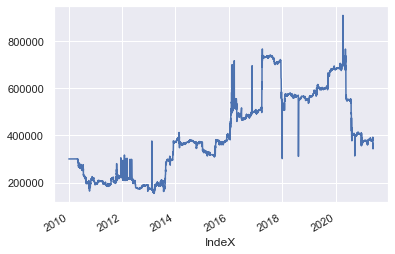

In [38]:
df_nav.Total.plot()

In [39]:
import ffn
def timerange1D(df):
    df['Date'] = df.index
    df['Date'] = df['Date'].dt.strftime(date_format='%Y-%m-%d')
    return(df.sort_index(axis=0))


#df_nav = timerange1D(df_nav)
stats = df_nav[['Total']].dropna().calc_stats()
stats['Total'].display()
print(col.Fore.CYAN+'\n\nMONTHLY RETURN FOR '+x+'\n',col.Style.RESET_ALL)
stats['Total'].display_monthly_returns()

Stats for Total from 2010-01-04 02:00:00 - 2021-05-28 17:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
15.60%              0.29  1.28%   -58.14%

Annualized Returns:
mtd     3m      6m       ytd     1y       3y       5y      10y    incep.
------  ------  -------  ------  -------  -------  ------  -----  --------
-8.00%  -8.37%  -14.78%  -6.91%  -37.24%  -14.92%  -6.36%  6.24%  1.28%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.29     0.18       0.28
mean    16.72%   5.38%      11.35%
vol     57.26%   30.30%     40.86%
skew    5.14     2.60       1.67
kurt    134.12   17.02      4.62
best    78.14%   59.24%     116.32%
worst   -44.51%  -25.59%    -45.33%

Drawdowns:
max      avg        # days
-------  -------  --------
-58.14%  -11.72%    173.22

Misc:
---------------  ------
avg. up month    4.75%
avg. down month  -4.53%
up year %     

In [45]:
df_all.shape, df_all.dropna().shape

((611944, 15), (611944, 15))

In [13]:
df_resultats.T['Cumul pnl'].sum()

535045.3714841794